In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import math

%config InlineBackend.figure_format = 'svg'

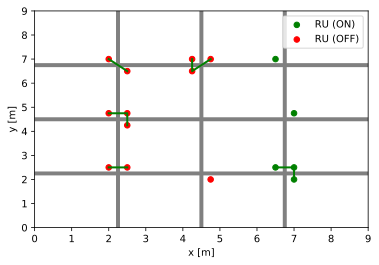

In [28]:
RU_DELTA = 0.25
JP_MIN_DELTA = 0.25
full_plot_line = np.arange(0, 10)

road0_y = np.array([3] * len(full_plot_line))
road0_x = np.array([3]  * len(full_plot_line))
road1_y = np.array([6] * len(full_plot_line))
road1_x = np.array([6]  * len(full_plot_line))


class UnionFind:
    """Union-find data structure. Items must be hashable."""

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, obj):
        """X[item] will return the token object of the set which contains `item`"""

        # check for previously unknown object
        if obj not in self.parents:
            self.parents[obj] = obj 
            self.weights[obj] = 1
            return obj 

        # find path of objects leading to the root
        path = [obj]
        root = self.parents[obj]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def union(self, obj1, obj2):
        """Merges sets containing obj1 and obj2."""
        roots = [self[obj1], self[obj2]]
        heavier = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heavier:
                self.weights[heavier] += self.weights[r]
                self.parents[r] = heavier


def groupTPL(R, distance=0.5):
    U = UnionFind()

    for (i, f) in enumerate(R):
        for j in range(i + 1, len(R)):
            s = R[j]
            if max(abs(f.x - s.x), abs(f.y - s.y)) <= distance:
                U.union((f.x, f.y), (s.x, s.y))

    disjSets = {}
    for x in R:
        s = disjSets.get(U[(x.x, x.y)], set())
        s.add((x.x, x.y))
        disjSets[U[(x.x, x.y)]] = s

    return [list(x) for x in disjSets.values()]               
                

class RU:
    def __init__(self, x, y, active):
        self.x = x
        self.y = y
        self.active = active
        
    def pointCmp(self, xx, yy):
        return self.x == xx and self.y == yy
        
class JP:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
class DU:
    def __init__(self, x,  y, active):
        self.x = x
        self.y = y
        self.active = active
        
def gen_ru(pairs):
    result = []
    for p in pairs:
        if (random.random() > 0.5):
            ru = RU(p[0] - RU_DELTA, p[1] - RU_DELTA, random.random() > 0.5)
            result.append(ru)
        if (random.random() > 0.5):
            ru = RU(p[0] + RU_DELTA, p[1] + RU_DELTA, random.random() > 0.5)
            result.append(ru)
        if (random.random() > 0.5):
            ru = RU(p[0] - RU_DELTA, p[1] + RU_DELTA, random.random() > 0.5)
            result.append(ru)
        if (random.random() > 0.5):
            ru = RU(p[0] + RU_DELTA, p[1] - RU_DELTA, random.random() > 0.5)
            result.append(ru)
       
    return result

def gen_jp(pairs):
    result = []
    for p in pairs:
        if (random.random() > 0.5):
            sign1 = [-1,1][random.randrange(2)]
            sign2 = [-1,1][random.randrange(2)]
            JP_DELTA = JP_MIN_DELTA + random.uniform(0.0, 0.3)
            jp = JP(p[0]  + sign1 *  JP_DELTA, p[1] + sign2 *JP_DELTA)
            result.append(jp)
        if (random.random() > 0.5):
            sign1 = [-1,1][random.randrange(2)]
            sign2 = [-1,1][random.randrange(2)]
            JP_DELTA = JP_MIN_DELTA + random.uniform(0.0, 0.3) 
            jp = JP(p[0] + sign1 * JP_DELTA, p[1] + sign2 * JP_DELTA)
            result.append(jp)
    return result

def gen_du(ju):
    result = []
    for j in ju:
        if (random.random() > 0.5):
            result.append(DU(j.x, j.y, True))
    
    return result

def cross_road_generator(count, grid_size = 9):
    place = grid_size / (count + 1)
    cross_points = []
    draw_result = []
    
    for r in range(count):
        draw_result.append([full_plot_line, np.array([place + place * r] * len(full_plot_line))])
        draw_result.append([np.array([place + place * r] * len(full_plot_line)), full_plot_line])
        cross_points.append(place + place * r)

    return [draw_result, [[p1, p2] for p1 in cross_points for p2 in cross_points]]


test_p = [[0] * 9,
    [0] * 9,
    [0] * 9,
     [0] * 9,
    [0] * 9,
    [0] * 9,
     [20] * 9,
     [20] * 9,
    [20] * 9,
     [20] * 9,
         ]

def is_inside(x, y, P):
    if 0 <= y < len(P[0]) and 0 <= x < len(P):
        return True


def sum_m(x, y, P):
    return sum([P[x][y],
                P[x][y - 1] if is_inside(x, y - 1, P) else 0,
                P[x][y + 1] if is_inside(x, y + 1, P) else 0,
                P[x - 1][y] if is_inside(x - 1, y, P) else 0,
                P[x + 1][y] if is_inside(x + 1, y, P) else 0,
                P[x - 1][y - 1] if is_inside(x - 1, y - 1, P) else 0,
                P[x - 1][y + 1] if is_inside(x - 1, y + 1, P) else 0,
                P[x + 1][y - 1] if is_inside(x + 1, y - 1, P) else 0,
                P[x + 1][y + 1] if is_inside(x + 1, y + 1, P) else 0
                ])


def get_new_R(ru, P):
    min_users = 20
    
    for r in ru:
        if sum_m(int(r.x), int(r.y), P) >= min_users:
            r.active = True
        else:
            r.active = False

#####################################################################################



def draw_ru(ru, ax):
    x = []
    y = []
    i_x = []
    i_y = []
    for r in ru:
        if r.active:
            x.append(r.x)
            y.append(r.y)
        else:
            i_x.append(r.x)
            i_y.append(r.y)
    
    ax.scatter(x, y, s=np.pi*10, c = "green", label="RU (ON)")
    ax.scatter(i_x, i_y, s=np.pi*10, c = "red", label="RU (OFF)")
        
def draw_jp(jp, ax):
    JP_COLOR = "#FFCC33"
    x = []
    y = []
    for j in jp:
        x.append(j.x)
        y.append(j.y)
    
    ax.scatter(x, y, s=np.pi*10, c = JP_COLOR, label="JP",  edgecolors='none')
    
def draw_du(du,  ax):
    x = []
    y = []
    for d in du:
        if d.active:
            x.append(d.x)
            y.append(d.y)
    
    ax.scatter(x, y, s=np.pi*10, c = "blue", label="DU",  edgecolors='none')
    
def draw_roads(cx, ax):
    for ro in cx:
        ax.plot(ro[0], ro[1], color='gray', linewidth=4)
        
        

def draw_current_state(c_x, J, R, D):
    fig, ax = plt.subplots()

    plt.axis([0, 9, 0, 9])

    draw_roads(c_x,  ax)
    #draw_jp(J, ax)
    get_new_R(R, test_p)
    draw_ru(R, ax)
    #draw_du(D, ax)
    
    groups = groupTPL(R)
    
    for g in groups:
        x = []
        y  = []
        for e in g:
            x.append(e[0])
            y.append(e[1])
        ax.plot(x, y, linewidth=2, color="green")

    
    ax.set(xlabel='x [m]', ylabel='y [m]')

    fig.savefig("streets.png")
    ax.legend()
    plt.show()
    


 

res = cross_road_generator(3)
cx =  res[0]
pairs = res[1]
JP_LIST = gen_jp(pairs)
RU_LIST = gen_ru(pairs)
DU_LIST = gen_du(JP_LIST)



draw_current_state(cx, JP_LIST,  RU_LIST, DU_LIST)


    

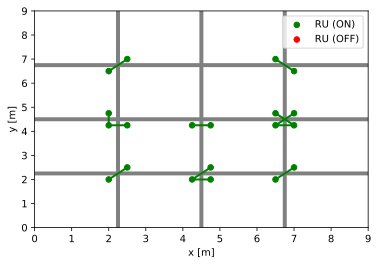

In [22]:

JP_LIST = gen_jp(pairs)
RU_LIST = gen_ru(pairs)
DU_LIST = gen_du(JP_LIST)
draw_current_state(cx, JP_LIST,  RU_LIST,DU_LIST)

# 2. DU Relocation

Let $x_{jt}$ is binary variable (0 or 1) that represent state of DU connection for *j*th JP at  *t*th perion

$X(t) =  \{x_{1t}, x_{2t}, \dots \}$ - denotes state of DU connection for JPs at state t

The relocation DUs is described as a transition between the states using $X(t)$ 